In [1]:
import gym
import torch
import gym_nav
import numpy as np

import sys
sys.path.append('../')
from evaluation import *
from model_evaluation import *
from trajectories import *
from shortcut_analysis import *
from explore_analysis import *

from tqdm import tqdm
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

pplt.rc.update({'font.size': 10})

In [13]:
chks = np.arange(40, 480, 40)

In [48]:
clone = 'actor1'
task = 1
p = 0.4
chk = 400
trial = 1

exp_name = f'plumtosc/plumtosc_{clone}_plumsched_1plumtask{task}p{p}'
# exp_name = f'scwplum/scwplum_schedule1p0.1'
model, obs_rms = load_chk(exp_name, trial=trial, chk=chk, subdir='')

env_kw = {'character_reset_pos': 3, 'shortcut_probability': 1, 'wall_colors': 1.5}
res = evaluate(model, obs_rms, env_name='ShortcutNav-v0', env_kwargs=env_kw,
        data_callback=shortcut_data_callback, num_episodes=50)

In [49]:
sur = np.mean([check_shortcut_usage(p) for p in res['data']['pos']])
print(sur)

0.1


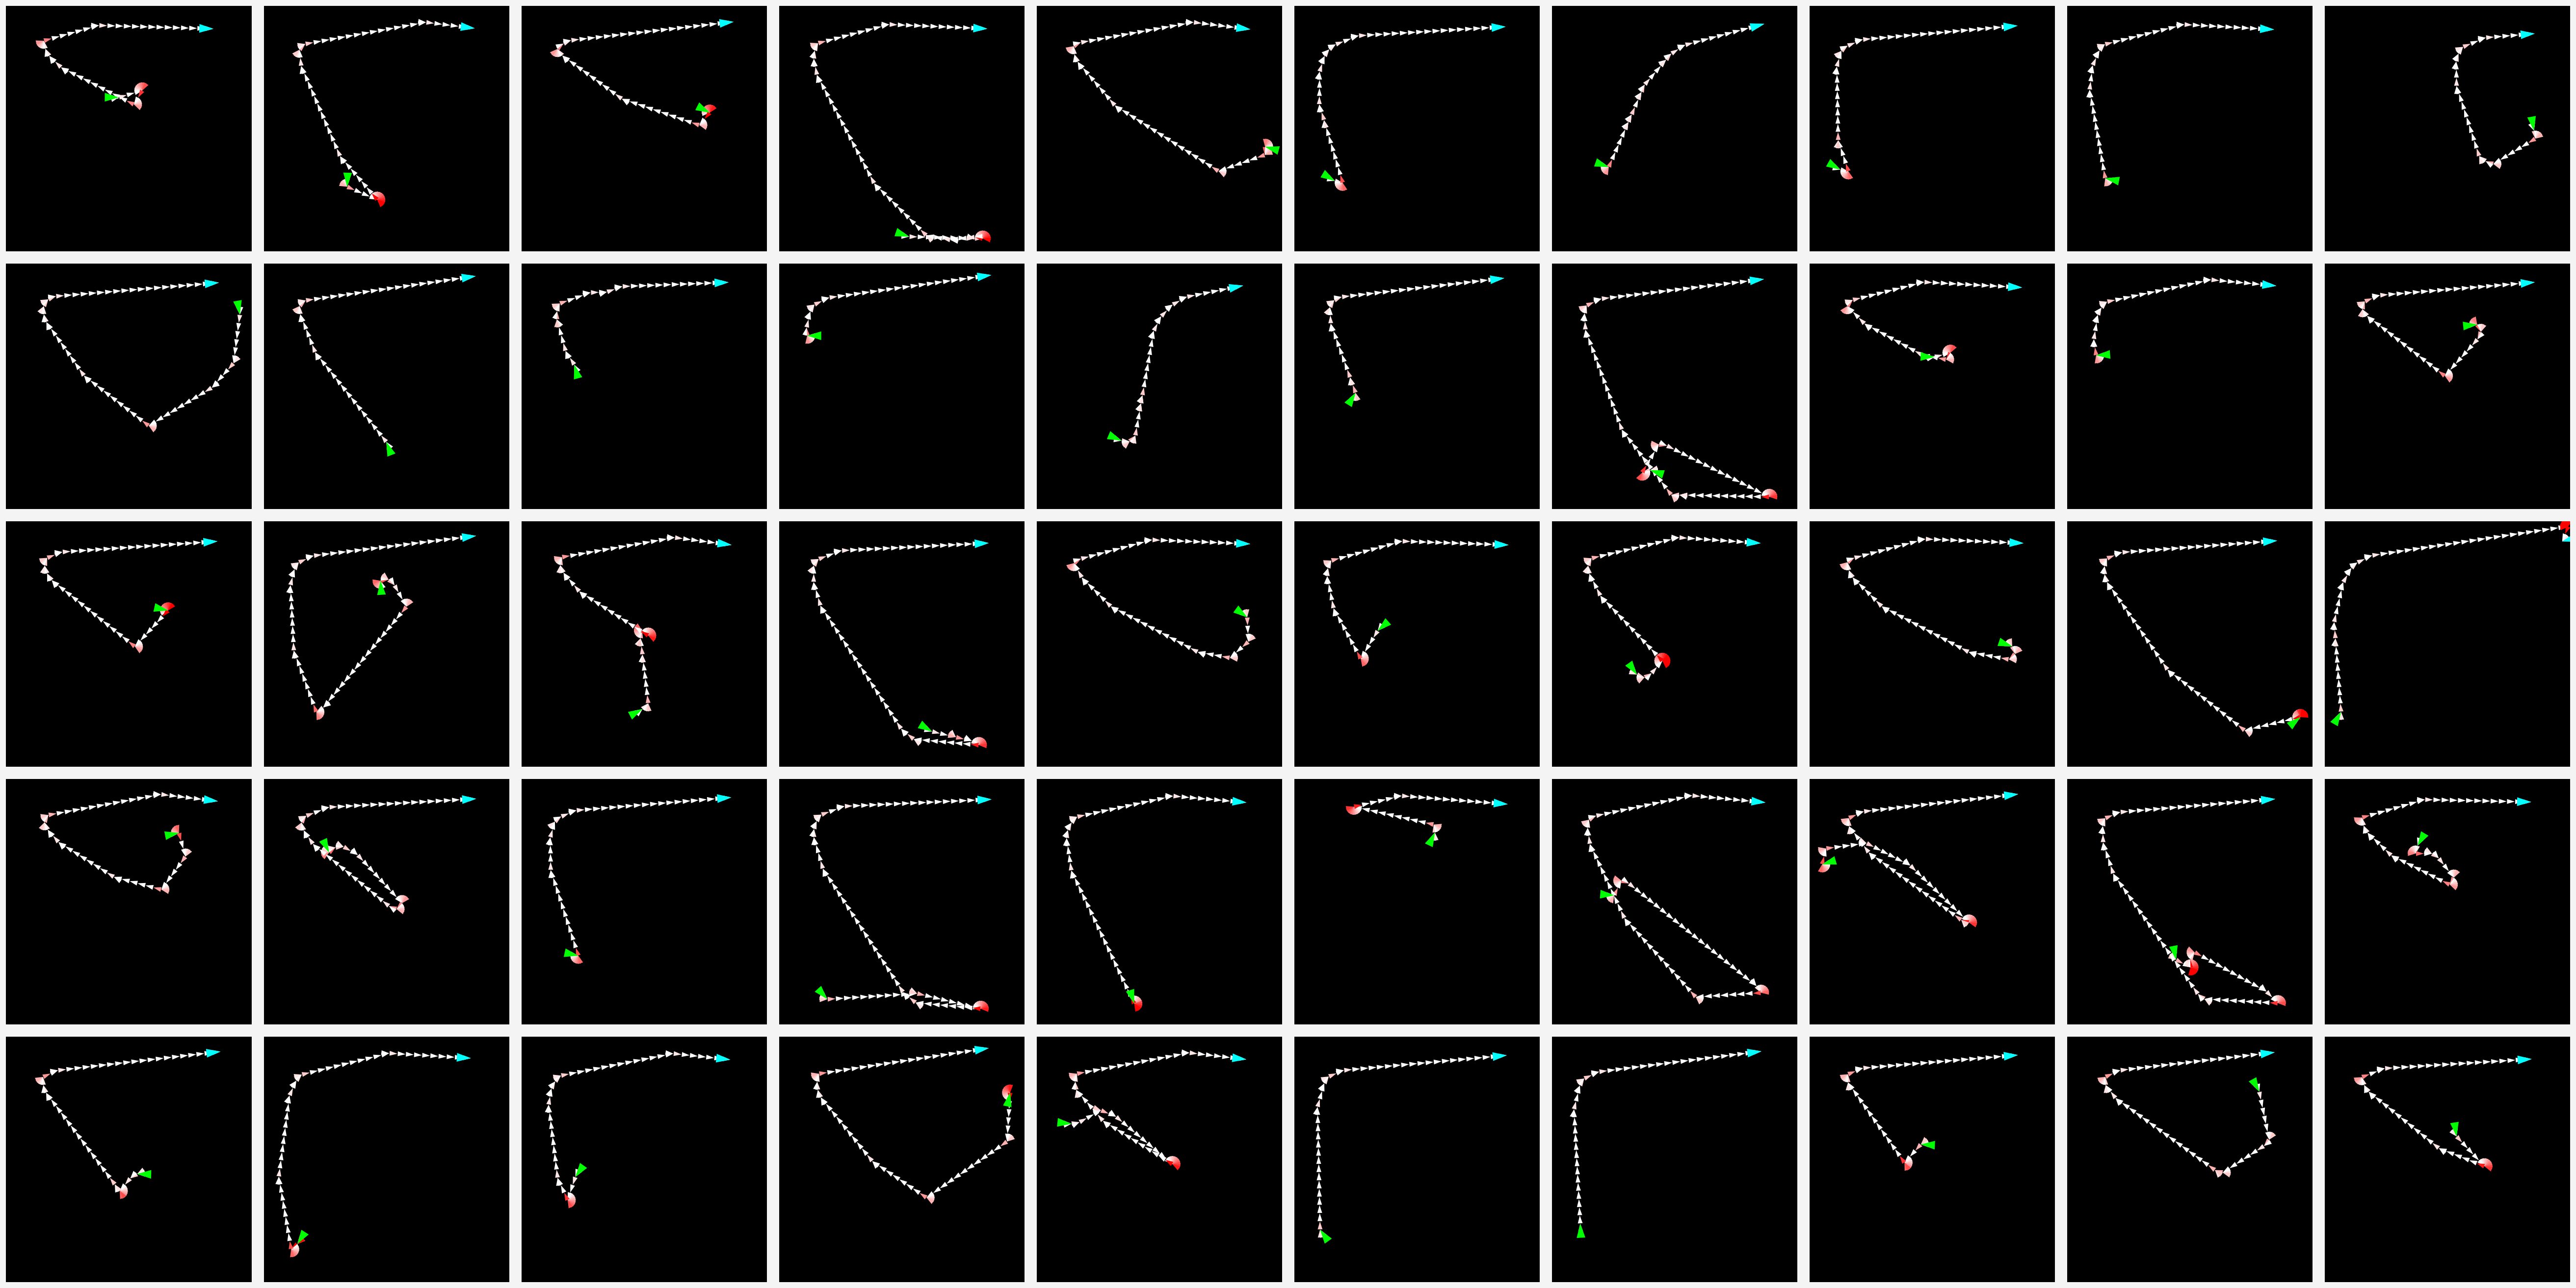

In [43]:
set_trajectory_plot_style()
fig, ax = pplt.subplots(nrows=5, ncols=10)
for i in range(50):
    p = res['data']['pos'][i]
    a = res['data']['angle'][i]
    draw_trajectory(p, a, ax=ax[i])
pplt.rc.reset()

In [51]:
num_episodes = 50
probs = [0.1, 0.4]
clone_sets = ['shared', 'actor0', 'actor1']
tasks = [1, 2] # original plum envs
trials = range(3)

for x, (task, clone, p, t) in enumerate(itertools.product(tasks, clone_sets, probs, trials)):
    key = f'{clone}_{task}_{p}_{t}'
    

# Data collection

In [56]:
chks = np.arange(40, 470, 40)
num_episodes = 50
probs = [0.1, 0.4]
clone_sets = ['shared', 'actor0', 'actor1']
tasks = [1, 2] # original plum envs
trials = range(3)

for x, (task, clone, p, t) in tqdm(enumerate(itertools.product(tasks, clone_sets, probs, trials)), total=36):
    if x < 30 and t == 1:
        continue
    key = f'{clone}_{task}_{p}_{t}'

    all_res = {
        'ws': [],
        'ns': []
    }

    for chk in chks:
        exp_name = f'plumtosc/plumtosc_{clone}_plumsched_1plumtask{task}p{p}'
        model, obs_rms = load_chk(exp_name, trial=t, chk=chk, subdir='')

        res = forced_action_evaluate(model, obs_rms, env_name='ShortcutNav-v0', 
                               env_kwargs={'character_reset_pos': 3,
                                          'shortcut_probability': 0,
                                          'wall_colors': 1.5},
                           seed=1, with_activations=True, data_callback=shortcut_visdata_callback,
                               num_episodes=num_episodes)

        '''Collect up to first+nth step of seeing shortcut
        where first is the first step seeing the shortcut'''
        activs = ep_stack_activations(res, half=True)

        all_res['ns'].append({
            'activs': activs,
            'actions': res['actions'],
            'ep_pos': res['data']['pos'],
            'ep_angle': res['data']['angle'],
            'vis': res['data']['shortcut_vis'],
            'shortcut': res['data']['shortcut']
        })
        
        res = forced_action_evaluate(model, obs_rms, env_name='ShortcutNav-v0', 
                       env_kwargs={'character_reset_pos': 3,
                                  'shortcut_probability': 1,
                                  'wall_colors': 1.5},
                   seed=1, with_activations=True, data_callback=shortcut_visdata_callback,
                       num_episodes=num_episodes)

        '''Collect up to first+nth step of seeing shortcut
        where first is the first step seeing the shortcut'''
        activs = ep_stack_activations(res, half=True)

        all_res['ws'].append({
            'activs': activs,
            'actions': res['actions'],
            'ep_pos': res['data']['pos'],
            'ep_angle': res['data']['angle'],
            'vis': res['data']['shortcut_vis'],
            'shortcut': res['data']['shortcut']
        })
        
    pickle.dump(all_res, open(f'data/shortcut/plum2sc_policy/{key}', 'wb'))

100%|███████████████████████████████████████████████████████████████████████████████| 36/36 [1:20:19<00:00, 133.87s/it]


# Strange behavior with plum scheduling

In [3]:
exp_name = 'scwplum/scwplum_schedule1p0.1'
model, obs_rms = load_chk(exp_name, chk=120, trial=0, subdir='')
env_kwargs = {'wall_colors': 1.5, 'character_reset_pos': 3,
              'shortcut_probability': 1, 'plum_pos': 3}
res = evaluate(model, obs_rms, env_name='ShortcutNav-v0', env_kwargs=env_kwargs,
         num_episodes=10, data_callback=shortcut_data_callback)

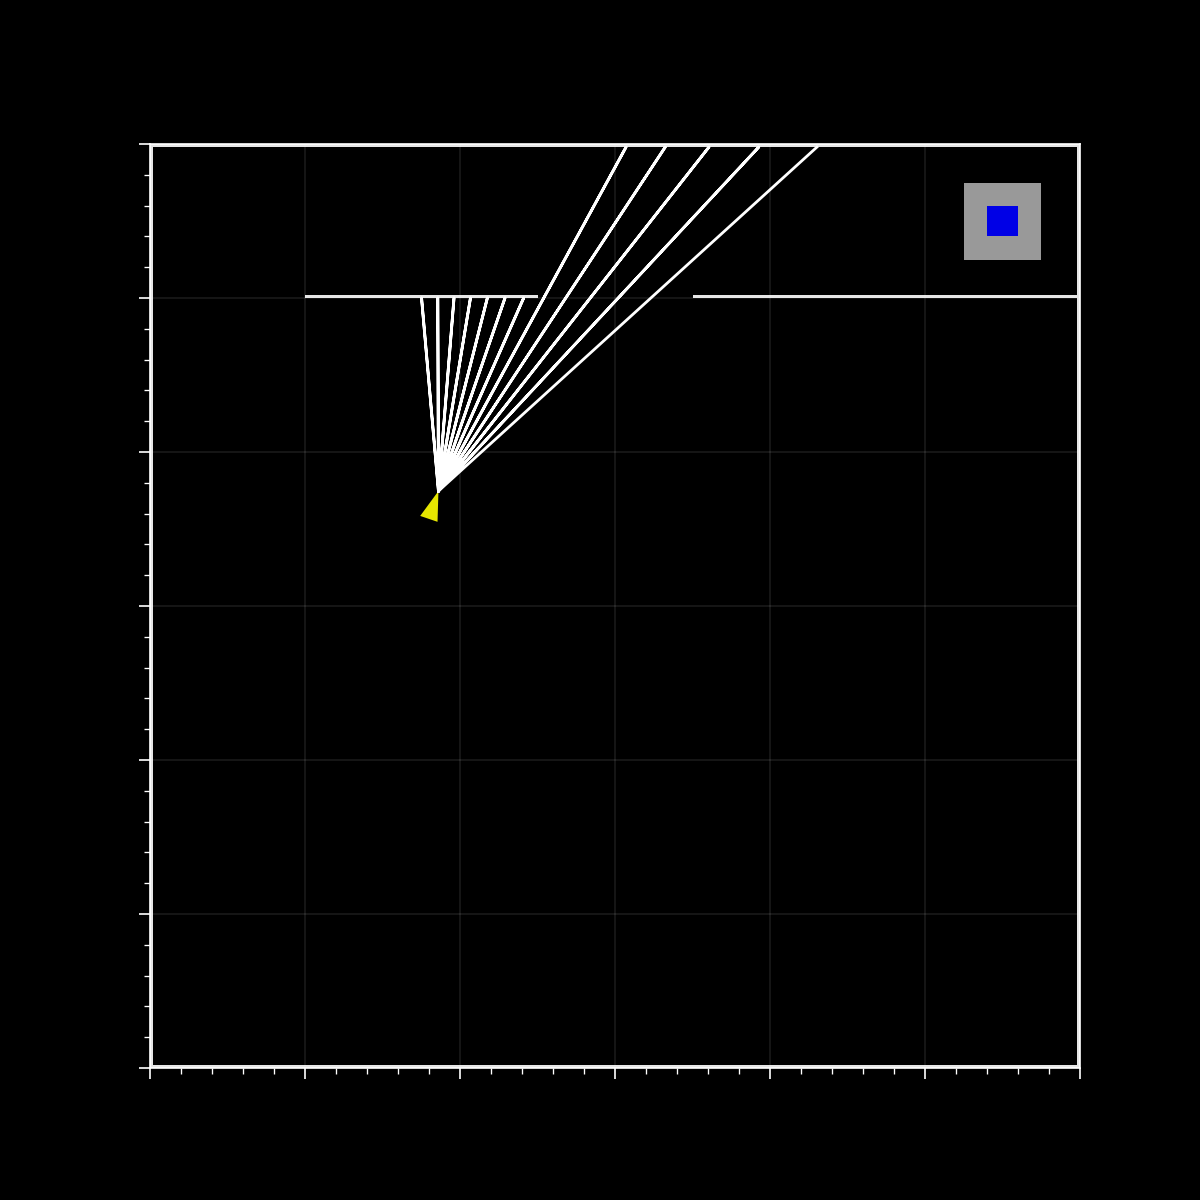

In [20]:
env_kwargs = {'wall_colors': 1.5, 'character_reset_pos': 3,
              'shortcut_probability': 1, 'plum_pos': 3}

env = gym.make('ShortcutNav-v0', **env_kwargs)
env.reset()
env.render('human')

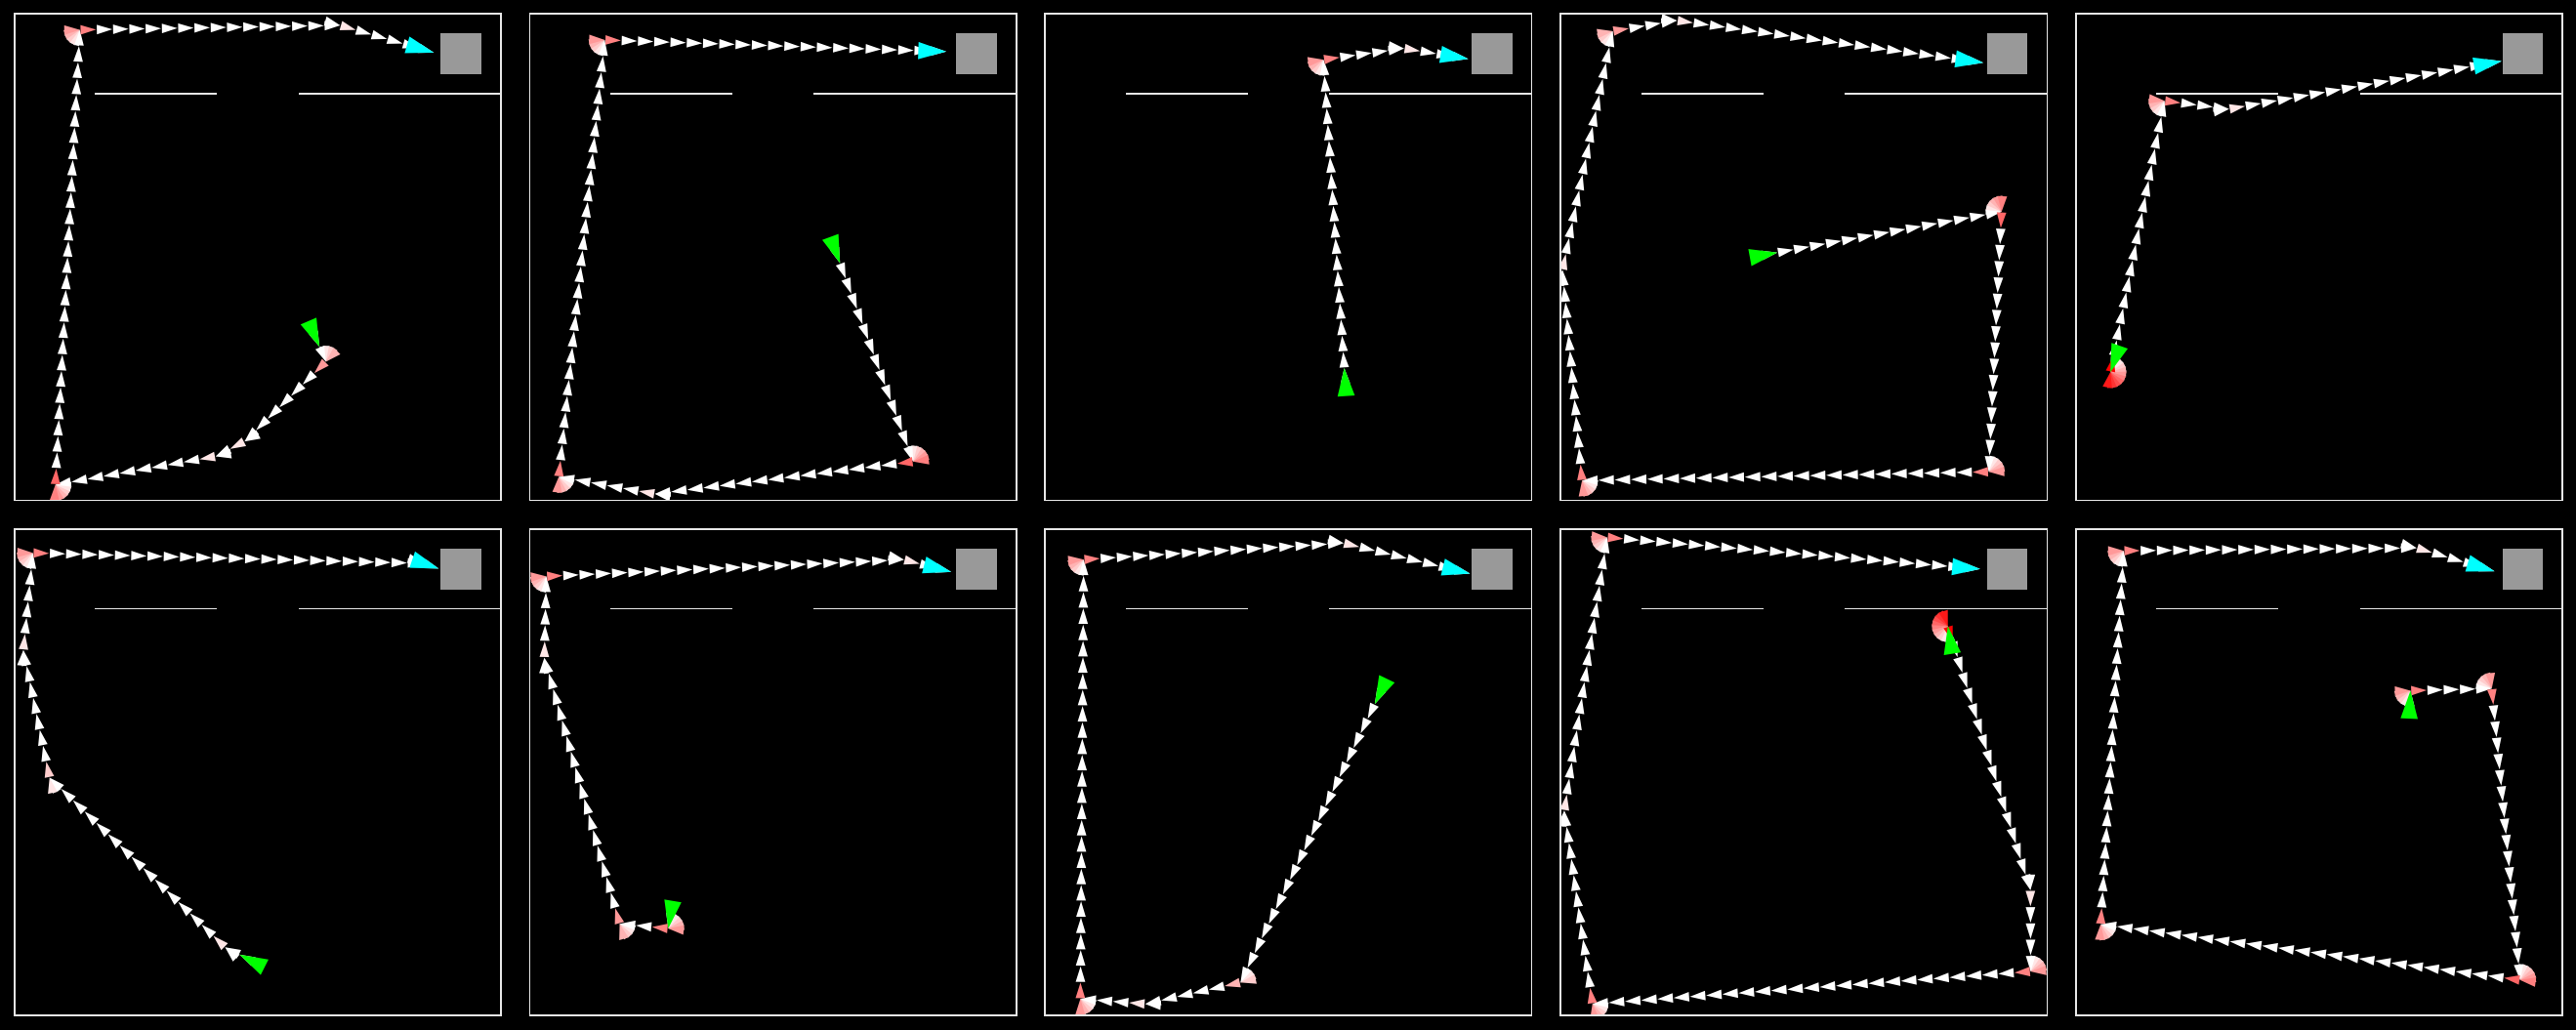

In [5]:
set_trajectory_plot_style()
fig, ax = pplt.subplots(nrows=2, ncols=5)

for i in range(10):
    p = res['data']['pos'][i]
    a = res['data']['angle'][i]
    draw_trajectory(p, a, ax=ax[i])
    draw_shortcut_maze(True, ax=ax[i])

pplt.rc.reset()
